This tutorial demonstrates how to build and train a Convolutional Neural Network (CNN) for image classification. The goal is to train a model that can classify images into the correct categories.

## Objectives
After completing this lab you will be able to:

*   Apply Convolutional Neural Network to classify images.




## <a id='toc1_2_'></a>[Setup](#toc0_)

For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/) for managing the data.
*   [`numpy`](https://numpy.org/) for mathematical operations.
*   [`matplotlib`](https://matplotlib.org/) for additional plotting tools.
*   [`sklearn`](https://scikit-learn.org/stable/) for machine learning and machine-learning-pipeline related functions.
*   [`torch`](https://pytorch.org/) for building and training the deep neural network.
*   [`torchvision`](https://pytorch.org/vision/stable/index.html) for computer vision tasks.

### <a id='toc1_2_2_'></a>[Importing Required Libraries](#toc0_)

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

## <a id='toc1_3_'></a>[Load the Data](#toc0_)

First, let's load our dataset and examine its structure.

The data comes from the paper [AniWho: A Quick and Accurate Way to Classify Anime Character Faces in Images](https://arxiv.org/pdf/2208.11012v3). The dataset consists of 9,738 images across 130 character classes, with approximately 75 images per class, sourced from the Danbooru website—a platform developed by the Japanese animation-style cartoon community.

For this tutorial, we will use a subset of the dataset. The zip file contains two subfolders: **Anastasia** and **Takao**, each with 50 images.

Let's unzip the dataset.


In [51]:
import io
import requests

def load_images_from_zip(zip_file):
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    images = {'anastasia': [], 'takao': []}
    for file_name in zip_ref.namelist():
      if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['anastasia'].append(np.array(img))
      elif file_name.startswith('takao') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['takao'].append(np.array(img))
  return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

# download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# load images from zip file
images = load_images_from_zip(zip_file_bytes)

In [52]:
print("Number of images of anastasia", len(images['anastasia']))
print("Number of images of takao", len(images['takao']))

Number of images of anastasia 50
Number of images of takao 50


## Visualize the Dataset

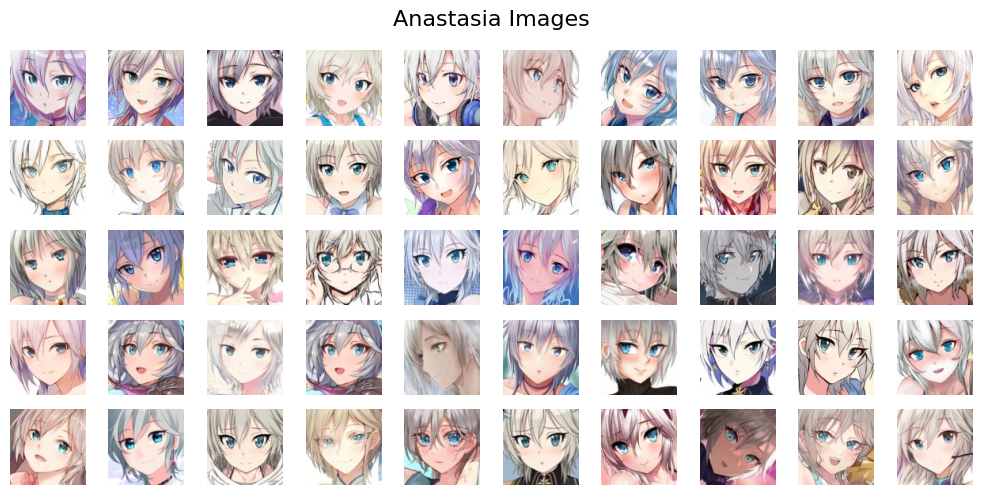

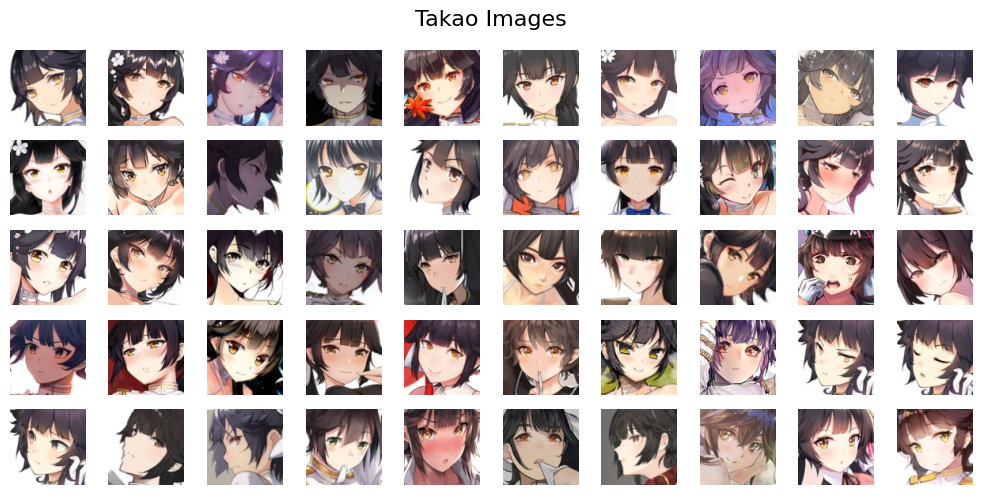

In [53]:
def plot_images(images, title):
  fig, axes = plt.subplots(5, 10, figsize=(10, 5))
  fig.suptitle(title, fontsize=16)
  axes = axes.flatten()

  for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')

  plt.tight_layout()
  plt.show()

# Plot images for 'anatasia'
plot_images(images['anastasia'], 'Anastasia Images')

# Plot images for 'takao'
plot_images(images['takao'], 'Takao Images')

## <a id='toc1_4_'></a>[Define Custom Dataset Class](#toc0_)

We need to define a custom dataset class to load our images. This class will inherit from `torch.utils.data.Dataset`.


In [54]:
class AnimeDataset(Dataset):

  def __init__(self, images, transform=None, classes=None):
    self.images = []
    self.labels = []
    self.transform = transform
    self.classes = classes

    for label, class_name in enumerate(self.classes):
      for img in images[class_name]:
        self.images.append(img)
        self.labels.append(label)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = Image.fromarray(self.images[index])
    label = self.labels[index]

    if self.transform:
      image = self.transform(image)

    return image, label

# Define transforms
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
)

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])

## <a id='toc1_5_'></a>[Split Dataset into Training and Validation Sets](#toc0_)

We will split the dataset into **training** and **validation** sets and create DataLoader for each.

The data is split into **80%** training and **20%** validation sets.

We then print the shapes of the training and test sets to verify that the data has been split correctly.


In [55]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

In [56]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

In [57]:
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [58]:
# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

In [59]:
print(train_indices)

[55, 88, 26, 42, 69, 15, 40, 96, 9, 72, 11, 47, 85, 28, 93, 5, 66, 65, 35, 16, 49, 34, 7, 95, 27, 19, 81, 25, 62, 13, 24, 3, 17, 38, 8, 78, 6, 64, 36, 89, 56, 99, 54, 43, 50, 67, 46, 68, 61, 97, 79, 41, 58, 48, 98, 57, 75, 32, 94, 59, 63, 84, 37, 29, 1, 52, 21, 2, 23, 87, 91, 74, 86, 82, 20, 60, 71, 14, 92, 51]


In [60]:
print(val_indices)

[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30, 73, 33, 90, 4, 76, 77, 12, 31]


In [61]:
# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [62]:
# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

In [63]:
# Print the sizes of the training and validation sets
print("Train Size", len(train_indices))
print("Validation size", len(val_indices))

Train Size 80
Validation size 20


## Define the CNN Model

In [64]:
import torch.nn.functional as F

class AnimeCNN(nn.Module):
  def __init__(self):
    super(AnimeCNN, self).__init__()
    # Add padding=1 to maintain the border
    self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*16*16, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64*16*16)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Instantiate the model
model = AnimeCNN()

In [65]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Let us print the tensor shapes of each layer in the model.


In [66]:
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
  print(f"{module.__class__.__name__} output size: {output.size()}")

# Register hooks
hooks = []
for layer in model.children():
  hook = layer.register_forward_hook(print_size)
  hooks.append(hook)

# Inspect output sizes
with torch.no_grad():
  output = model(input_tensor)

print("Final output size:", output.size())

# Remove hooks
for hook in hooks:
  hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


## <a id='toc1_7_'></a>[Define Loss Function and Optimizer](#toc0_)

We need to define the loss function and the optimizer. We will use CrossEntropyLoss and Adam optimizer.

`CrossEntropyLoss` is used for multi-class classification problems.

`Adam` is a popular optimization algorithm that is an extension of the stochastic gradient descent algorithm.

In [67]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## <a id='toc1_8_'></a>[Train the Model](#toc0_)

Now, let's train the model with our training data. We iterate over the training data for a specified number of epochs and update the weights of the neural network using backpropagation.

During training, we calculate the loss at each epoch and print it to monitor the training progress. The loss should decrease over time as the model learns to classify the Animes correctly.

In [68]:
# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss/len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finish Training')

Epoch 1, Train Loss: 0.7333, Val Loss: 0.1828
Epoch 2, Train Loss: 0.1857, Val Loss: 0.0011
Epoch 3, Train Loss: 0.0471, Val Loss: 0.0005
Epoch 4, Train Loss: 0.0086, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0002
Finish Training


## <a id='toc1_9_'></a>[Visualize the Training and Test Loss](#toc0_)

We have successfully trained our model. Let's now visualize the training and test loss.

Plotting the loss curves helps us understand the training dynamics of our model.

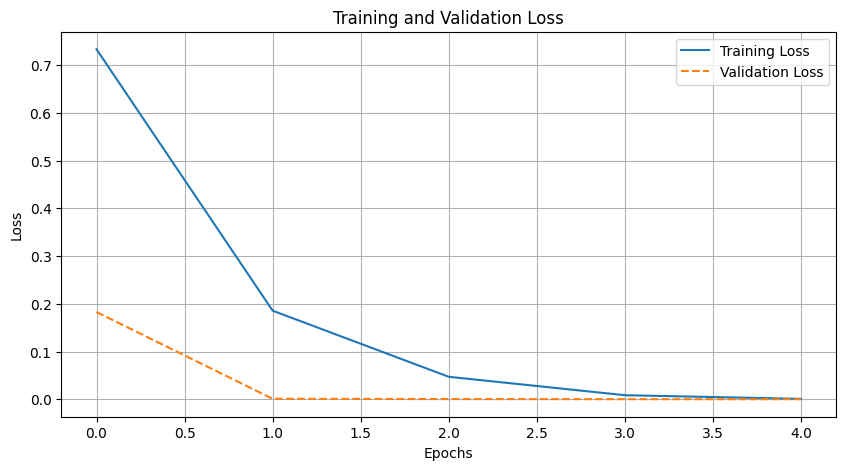

In [69]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [70]:
# Function to display an image
def display_image(img, ax):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  ax.imshow(np.transpose(npimg, (1,2,0))) # Transpose dimensions to match matplotlib's expected format
  ax.axis('off')

In [71]:
# Set model to evaluation mode
model.eval()

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

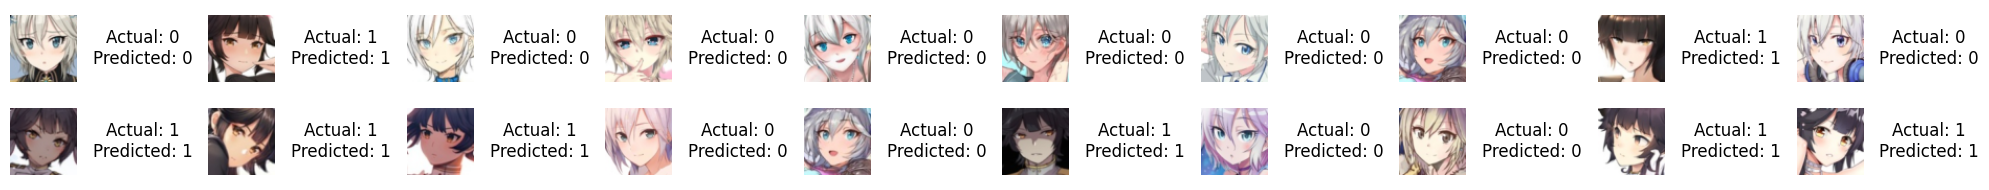

In [72]:
data_iter = iter(val_loader)
images, label = next(data_iter)
output = model(images)
_,predicted = torch.max(output, 1)

# define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols*2, figsize=(20, num_rows))

for idx in range(num_images):
  row = idx // num_cols
  col = (idx % num_cols) * 2

  # plot the image
  display_image(images[idx].cpu(), axs[row, col])

  # Display actual and predicted labels
  axs[row, col+1].text(0.5, 0.5, f"Actual: {label[idx].item()}\nPredicted: {predicted[idx].item()}", horizontalalignment='center', verticalalignment='center', fontsize=12)
  axs[row, col+1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
  row = idx // num_cols
  col = (idx % num_cols) * 2
  axs[row, col].axis('off')
  axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [73]:
print(val_loader.dataset.classes)

['anastasia', 'takao']


In [74]:
correct = 0
total = 0
with torch.no_grad():
  for data in val_loader:
    images, labels = data
    outputs = model(images)
    _,predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  good = correct / total
  print(f"Correct: {correct}, total: {total}")
  print(f"Accuracy is: {100*good} %")

Correct: 20, total: 20
Accuracy is: 100.0 %


## <a id='toc1_10_'></a>[Exercises](#toc0_)


### <a id='toc1_10_1_'></a>[Exercise 1 - Change activation function to `leaky_relu`](#toc0_)


In [75]:
class AnimeCNNModified(nn.Module):
  def __init__(self):
    super(AnimeCNNModified, self).__init__()
    # Add padding = 1 t maintain the border
    self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1 , padding=1)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*16*16, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.leaky_relu(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = F.leaky_relu(x)
    x = self.maxpool(x)
    x = x.view(-1, 64*16*16)
    x = self.fc1(x)
    x = F.leaky_relu(x)
    x = self.fc2(x)
    return x

### <a id='toc1_10_2_'></a>[Exercise 2 - Increase the number of epochs and observe the training and validation loss](#toc0_)

After increasing the number of epochs, you should observe that the training and validation loss decrease further. However, it may stop decreasing after a certain number of epochs.


Epoch 1, Train Loss: 0.4002, Val Loss: 0.0104
Epoch 2, Train Loss: 0.0632, Val Loss: 0.0005
Epoch 3, Train Loss: 0.0155, Val Loss: 0.0001
Epoch 4, Train Loss: 0.0050, Val Loss: 0.0001
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0000
Epoch 6, Train Loss: 0.0004, Val Loss: 0.0000
Epoch 7, Train Loss: 0.0003, Val Loss: 0.0000
Finish Training


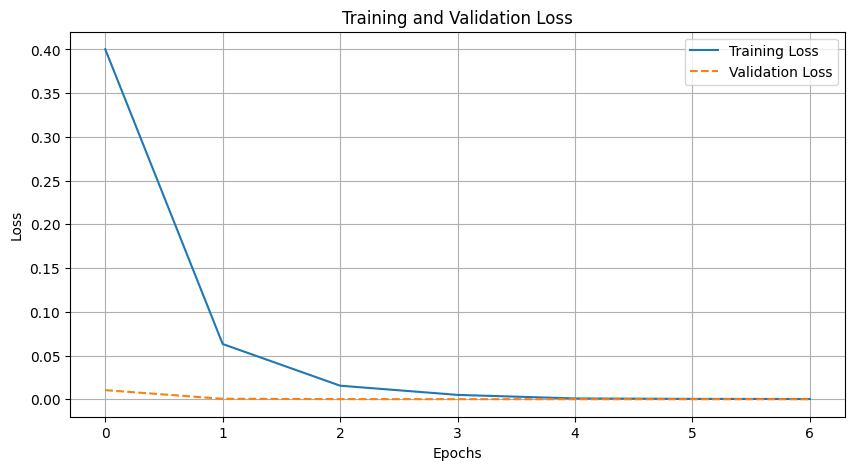

In [79]:
# Training loop
num_epochs = 7
train_losses = []
val_losses = []
model = AnimeCNNModified()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss/len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finish Training')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

### <a id='toc1_10_3_'></a>[Exercise 3 - Use different character classes for training and validation](#toc0_)

You can find the code for reading the data below. Please follow the same steps to classify images from different character classes.

This practice data contains images of two characters: **arcueid_brunestud** and **yukinoshita_yukino**.


In [81]:
import io
import requests

def load_images_from_zip(zip_file):
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    images = {'arcueid_brunestud': [], 'yukinoshita_yukino': []}
    for file_name in zip_ref.namelist():
      if file_name.startswith('arcueid_brunestud') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['arcueid_brunestud'].append(np.array(img))
      elif file_name.startswith('yukinoshita_yukino') and file_name.endswith('.jpg'):
        with zip_ref.open(file_name) as file:
          img = Image.open(file).convert('RGB')
          images['yukinoshita_yukino'].append(np.array(img))
  return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/yNB99OssvDWOrNTHf2Yuxw/data-practice.zip'

# download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# load images from zip file
images = load_images_from_zip(zip_file_bytes)

print("Number of images of arcueid_brunestud", len(images['arcueid_brunestud']))
print("Number of images of yukinoshita_yukino", len(images['yukinoshita_yukino']))

Number of images of arcueid_brunestud 50
Number of images of yukinoshita_yukino 50


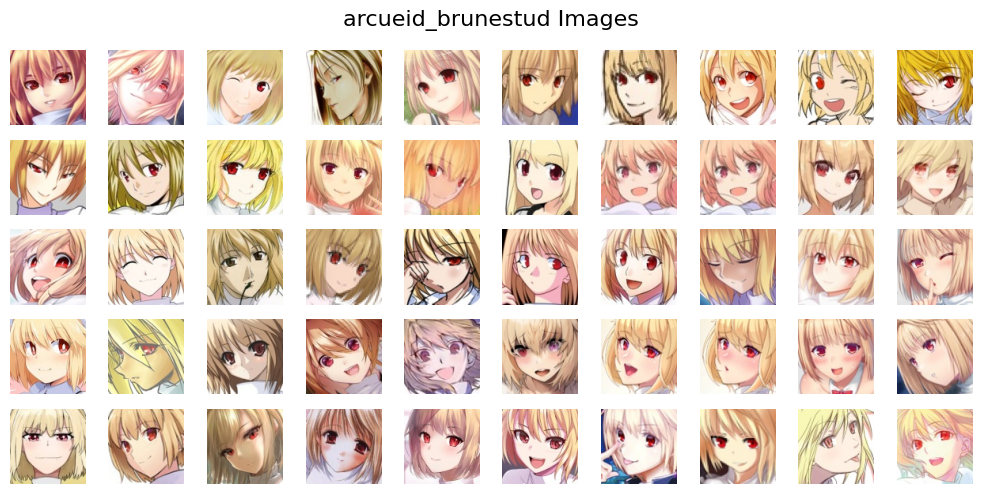

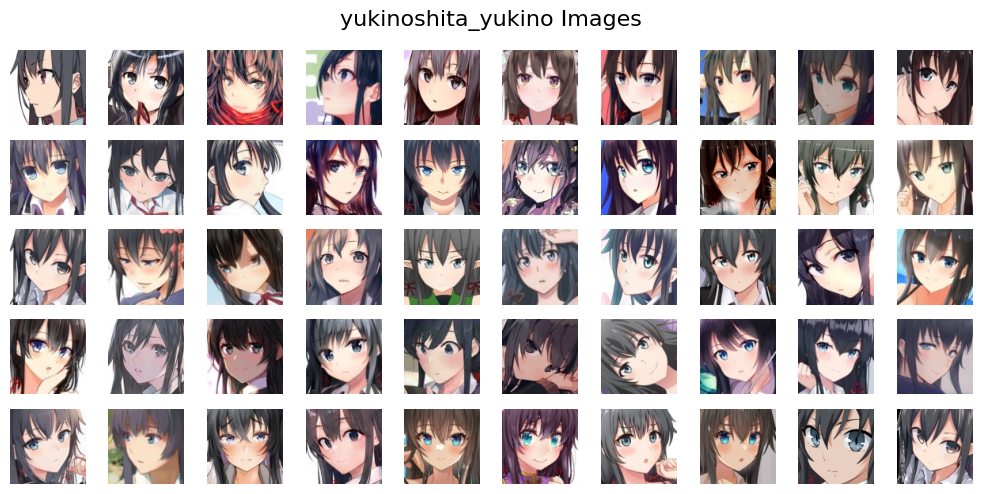

In [82]:
# Plot images for 'arcueid_brunestud'
plot_images(images['arcueid_brunestud'], 'arcueid_brunestud Images')

# Plot images for 'yukinoshita_yukino'
plot_images(images['yukinoshita_yukino'], 'yukinoshita_yukino Images')

In [87]:
# TODO: Define a new AnimeDataset object for the new dataset.
# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['arcueid_brunestud', 'yukinoshita_yukino'])
# TODO: Split the new dataset into training and validation sets.
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
# TODO: Create DataLoader objects for the new training and validation sets.
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

Epoch 1, Train Loss: 0.3395, Val Loss: 0.0264
Epoch 2, Train Loss: 0.0452, Val Loss: 0.0003
Epoch 3, Train Loss: 0.0386, Val Loss: 0.0003
Epoch 4, Train Loss: 0.0000, Val Loss: 0.0021
Epoch 5, Train Loss: 0.0003, Val Loss: 0.0120
Epoch 6, Train Loss: 0.0009, Val Loss: 0.0060
Epoch 7, Train Loss: 0.0002, Val Loss: 0.0015
Finish Training


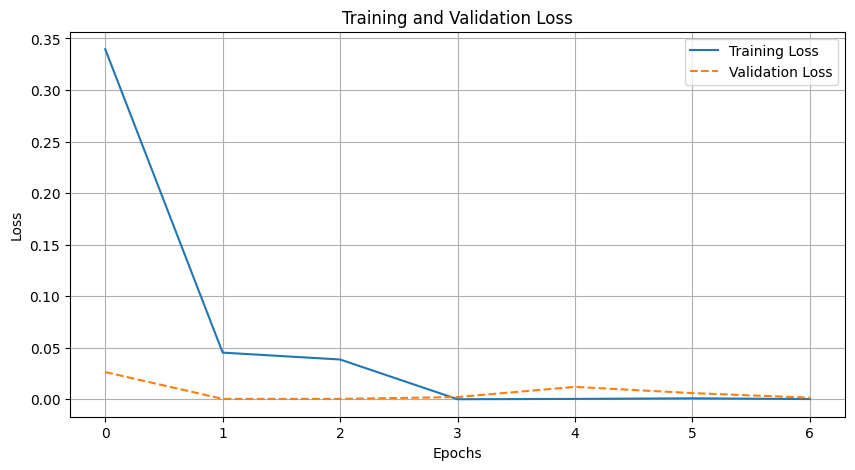

In [88]:
# TODO: Define a new CNN model and train it on the new dataset.
# Training loop
num_epochs = 7
train_losses = []
val_losses = []
model = AnimeCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss/len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)

  print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finish Training')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

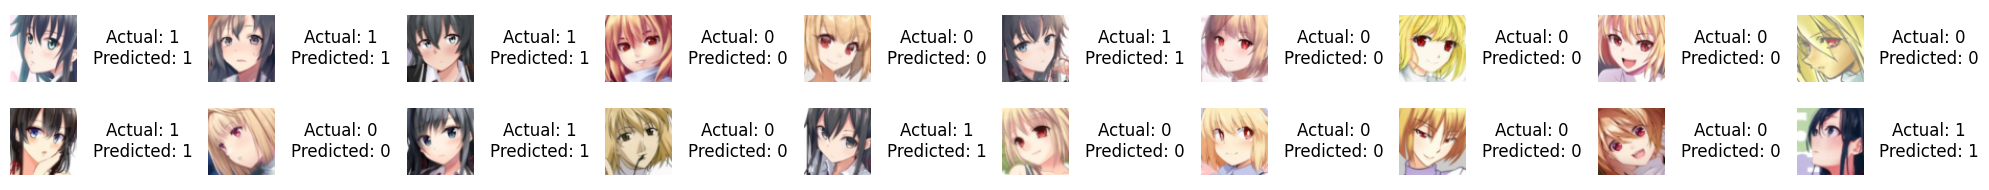

In [89]:
# TODO: Evaluate the new model on the validation set.
data_iter = iter(val_loader)
images, label = next(data_iter)
output = model(images)
_,predicted = torch.max(output, 1)

# define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols*2, figsize=(20, num_rows))

for idx in range(num_images):
  row = idx // num_cols
  col = (idx % num_cols) * 2

  # plot the image
  display_image(images[idx].cpu(), axs[row, col])

  # Display actual and predicted labels
  axs[row, col+1].text(0.5, 0.5, f"Actual: {label[idx].item()}\nPredicted: {predicted[idx].item()}", horizontalalignment='center', verticalalignment='center', fontsize=12)
  axs[row, col+1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
  row = idx // num_cols
  col = (idx % num_cols) * 2
  axs[row, col].axis('off')
  axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [90]:
print(val_loader.dataset.classes)
correct = 0
total = 0
with torch.no_grad():
  for data in val_loader:
    images, labels = data
    outputs = model(images)
    _,predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  good = correct / total
  print(f"Correct: {correct}, total: {total}")
  print(f"Accuracy is: {100*good} %")

['arcueid_brunestud', 'yukinoshita_yukino']
Correct: 20, total: 20
Accuracy is: 100.0 %
